In [1]:
import os
import torch
import matplotlib.pyplot as plt
import xml.dom.minidom
from skimage.io import imread
from skimage import img_as_ubyte
from pyrr import Matrix44, Vector4, Vector3
import pyrr

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, 
    BlendParams,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader,
    SoftSilhouetteShader
)
from pytorch3d.renderer.cameras import look_at_view_transform

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from tqdm import tqdm
import torch.nn as nn
import imageio
import cv2
import copy
from PIL import ImageFont, ImageDraw, Image

import wandb

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import pytorch3d
from pytorch3d_utils import where, mitsuba_scene_to_torch_3d_no_ground, add_background, get_body_image_from_mesh

In [2]:
class Model(nn.Module):
    def __init__(self, texTshirt, texOther, verticies, faces, renderer, silhouette_renderer, body_estimation):
        super().__init__()
        self.device = torch.device("cuda:0")
        self.silhouette_renderer = silhouette_renderer
        self.renderer = renderer
        self.texOther = texOther
        self.verticies = verticies
        self.faces = faces
        self.body_estimation = body_estimation
        self.cur_mesh = None
        
        self.texTshirt = nn.Parameter(
            torch.zeros_like(texTshirt).to(self.device)
        )
        
        ## loss functions
        
        self.objective = torch.nn.MSELoss()
        self.zero_heatmap = torch.zeros((1, 19, 64, 64), device=self.device)
        self.zero_paf = torch.zeros((1, 38, 64, 64), device=self.device)
        
        self.bg_path = '../data/backgrounds/test/indoor_20.jpg'

    def forward(self):        
        tex = torch.cat([self.texTshirt, self.texOther])[None]  # (1, 204, 3)
        textures = Textures(verts_rgb=tex.cuda())
        
        self.cur_mesh = Meshes(verts=[self.verticies], faces=[self.faces], textures=textures)
        final_images = add_background(self.bg_path, self.cur_mesh, self.renderer, self.silhouette_renderer)
        
        body_input = (final_images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
        paf, heat = self.body_estimation.model(body_input)
        
        ob_val_heat = self.objective(heat, self.zero_heatmap)
        ob_val_paf = self.objective(paf, self.zero_paf)
        
        # Calculate the silhouette loss
        loss = ob_val_heat + ob_val_paf
        return loss, final_images
    

def wandb_init(name):
    run = wandb.init(
        project = "mts_tshirt_single", 
        reinit = True,
        name = name,
        config={
            "steps": 100,
            "learning_rate": 0.2
        }
    )
    
    return run 



Text(0.5, 1.0, 'With background')

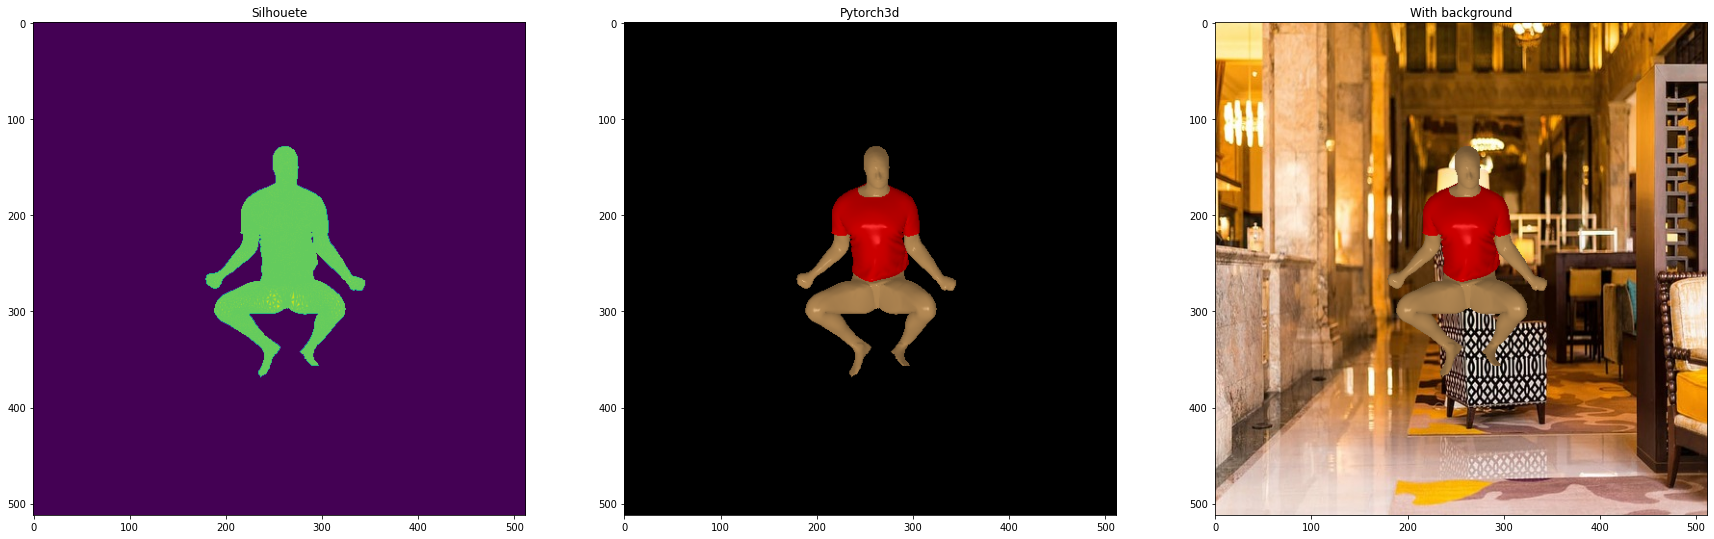

In [3]:
ORIG_SHAPE = (512, 512, 3)
BG_PATH = '../data/backgrounds/test/indoor_20.jpg'
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
master_scene = 'data/radek/00008_mesh88_animated.xml'
mesh, cameras, optmization_input = mitsuba_scene_to_torch_3d_no_ground(master_scene, 'data/radek')

raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1,
    perspective_correct=True,
#     max_faces_per_bin=100000,
#     bin_size=64
)
lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

image = renderer(mesh)   # (1, H, W, 4)
silhouette = silhouette_renderer(mesh)   # (1, H, W, 4)

background = cv2.imread(BG_PATH)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
background = torch.from_numpy(background / 255).unsqueeze(0).float().cuda()
alpha = torch.ones((1, 512, 512, 1)).cuda()
background = torch.cat([background, alpha], 3)


alpha_mask = torch.cat([silhouette[..., 3], silhouette[..., 3], silhouette[..., 3], silhouette[..., 3]], 0)
alpha_mask = alpha_mask.unsqueeze(0).permute((0, 2, 3, 1))

final = where(alpha_mask > 0, image, background)

silhouette = silhouette.cpu().numpy()
final = final.cpu().numpy()


fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(silhouette.squeeze()[..., 3])

ax.set_title("Silhouete")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(image.squeeze().cpu().numpy())
ax.set_title("Pytorch3d")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(final.squeeze())
ax.set_title("With background")

In [4]:
ORIG_SHAPE = (512, 512, 3)

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

reg = 0.001
# Initialize a model using the renderer, mesh and reference image
model = Model(
    texTshirt=optmization_input["texTshirt"], 
    texOther=optmization_input["texOther"], 
    verticies=optmization_input["verticies"], 
    faces=optmization_input["faces"], 
    renderer=renderer,
    silhouette_renderer=silhouette_renderer, 
    body_estimation=body_estimation
).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
filename_output = f"./gifs/texture_single_tshirt_vertex_bg.gif"
#run = wandb_init('torch3d vertex placements')
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

In [5]:
font = ImageFont.truetype("arial.ttf", 20)
losses = []
for i in tqdm(range(100)):
    optimizer.zero_grad()
    loss, cur_image = model()
    loss.backward()
    optimizer.step()
    #wandb.log({'loss': loss.item()}, step=i)
    losses.append(loss.item())
    
    # Save outputs to create a GIF. 
    rendering_torch_input = (cur_image[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
    
    heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
    candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
    rendering_torch_np =  cur_image[0, ..., :3].detach().squeeze().cpu().numpy()
    canvas = copy.deepcopy(rendering_torch_np)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    canvas = np.clip(canvas, -1, 1)
    canvas = img_as_ubyte(canvas)
    
    # addtext 
    pil_im = Image.fromarray(canvas)
    draw = ImageDraw.Draw(pil_im)
    draw.text((0, 0), f"it: {i}", font=font)

    
    writer.append_data(np.array(pil_im))
    
writer.close()

100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


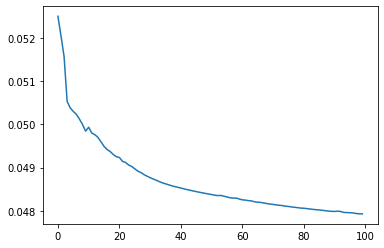

In [6]:
plt.plot(losses)

![SegmentLocal](gifs/texture_single_tshirt_vertex_bg.gif "segment")

In [7]:
(canvas_orig, 
 candidate_orig,
 subset_orig,
 heatmap_avg_orig,
 paf_avg_orig) = get_body_image_from_mesh(mesh, body_estimation, renderer, silhouette_renderer, ORIG_SHAPE, BG_PATH)

(canvas_noise, 
 candidate_noise,
 subset_noise,
 heatmap_avg_noise,
 paf_avg_noise) = get_body_image_from_mesh(model.cur_mesh, body_estimation, renderer, silhouette_renderer, ORIG_SHAPE, BG_PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Adv')

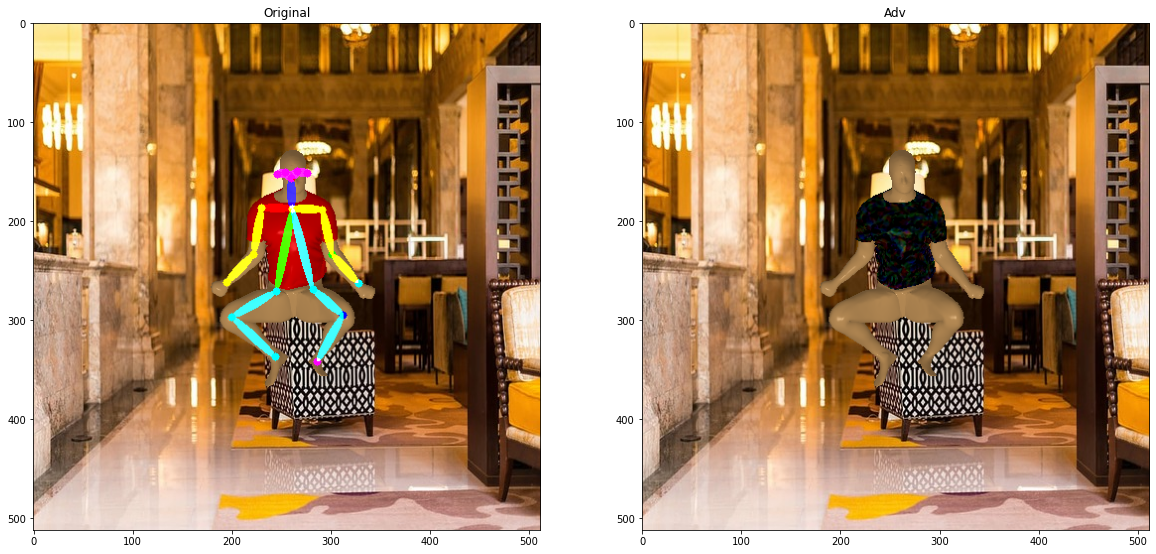

In [8]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(canvas_orig)
ax.set_title('Original')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(canvas_noise)
ax.set_title('Adv')

In [9]:
filename_output = "./noise_single_tshirt.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.30)
for rot in tqdm(range(0, 360, 4)):
    R, T = look_at_view_transform(10.0, 1, rot) 
    T[0, 1] = -1.0
    cur_image = renderer(model.cur_mesh,  R=R.cuda(), T=T.cuda())
    
    cur_image = cur_image[0, ..., :3].detach().squeeze().cpu().numpy()
    cur_image = np.clip(cur_image, -1, 1)
    cur_image = img_as_ubyte(cur_image)
    writer.append_data(cur_image)
    
writer.close()

100%|██████████| 90/90 [00:05<00:00, 15.95it/s]


![SegmentLocal](noise_single_tshirt.gif "segment")